# Deep Learning Authorship Attribution
#### W266 Final Project
#### Derrick Xiong, John Schulz

## Introduction
Authorship attribution is the process of identifying the author of a given text and from the machine learning perspective, it can be seen as a classification problem.In this report, we outlined the results we obtained for the W266 final project. The project was based on using deep learning models such as Convolutional Neural network, recurrent neural networks model with LSTM(long short-term memory cell). We used this state-of-the-art model for the problem of Victorian authorship attribution. The problem of attributing authorship has been a well-known problem in NLP with a large amount of human benchmarks available.
We used the CNN model as our baseline and planned to use a model better suited for NLP such as LSTM and other state-of-the-art pre-training models such as BERT to improve our results. The results are..


## Import Necessary Libraries

In [52]:
import numpy as np 
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.utils import shuffle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Conv1D, MaxPooling1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from keras.utils import plot_model
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from PIL import Image
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn import metrics 
from sklearn.metrics import plot_confusion_matrix
import seaborn as sn

## Load Data and Clean
Data Provided from this UC Irvine Machine Learning Data Set: [Victorian Era Authorship Attribution Data Set](https://archive.ics.uci.edu/ml/datasets/Victorian+Era+Authorship+Attribution#)

Data Cleaning Process:
- Data was cleaned by lemmatisizing or stemming all words in the provided dataset
- Stop words were also removed to eliminate noise in our model

In [2]:
df = pd.read_csv('dataset/Gungor_2018_VictorianAuthorAttribution_data-train.csv', encoding='latin-1')
df

,text,author
0,ou have time to listen i will give you the ent...,1
1,wish for solitude he was twenty years of age a...,1
2,and the skirt blew in perfect freedom about th...,1
3,of san and the rows of shops opposite impresse...,1
4,an hour s walk was as tiresome as three in a s...,1
...,...,...
53673,after surrounding and searching the whole plac...,50
53674,giant who could make a young earthquake or a w...,50
53675,waters of the lake at the bottom of the hill c...,50
53676,fingers and thumb in it exactly as it came out...,50


In [3]:
lemmatiser = WordNetLemmatizer()
stop_words = stopwords.words('english')
cleaned_text = []
for text in df['text']:
    lemmatised_words =''
    split_text = text.split()
    for word in split_text:
        if word not in stop_words:
            lemmatised_word=lemmatiser.lemmatize(word, pos="v")
            lemmatised_words += lemmatised_word + ' '
    cleaned_text.append(lemmatised_words)
df['text clean'] = cleaned_text
df

,text,author,text clean
0,ou have time to listen i will give you the ent...,1,ou time listen give entire story say may form ...
1,wish for solitude he was twenty years of age a...,1,wish solitude twenty years age possession perf...
2,and the skirt blew in perfect freedom about th...,1,skirt blow perfect freedom upper part wear hat...
3,of san and the rows of shops opposite impresse...,1,san row shop opposite impress upon vision last...
4,an hour s walk was as tiresome as three in a s...,1,hour walk tiresome three sensible english town...
...,...,...,...
53673,after surrounding and searching the whole plac...,50,surround search whole place could discover tra...
53674,giant who could make a young earthquake or a w...,50,giant could make young earthquake angry accord...
53675,waters of the lake at the bottom of the hill c...,50,water lake bottom hill curl kindness sympathy ...
53676,fingers and thumb in it exactly as it came out...,50,finger thumb exactly come hand never mind say ...


## Exploratory Data Analyses 
Exloring the words most commonly used by a few authors

In [4]:
one_sample_per_author = df.groupby('author').head(1)
one_sample_per_author.head(5)

,text,author,text clean
0,ou have time to listen i will give you the ent...,1,ou time listen give entire story say may form ...
912,who might have had rich miss asking so of both...,2,might rich miss ask party â nobody surprise ol...
1294,led forward avoiding the rough places in the f...,3,lead forward avoid rough place forest path hal...
1507,in her lips that were parted just then in a of...,4,lips part silent delight mirth stand top step ...
2990,district of new to maria â s a slight expressi...,6,district new maria â slight expression writer ...


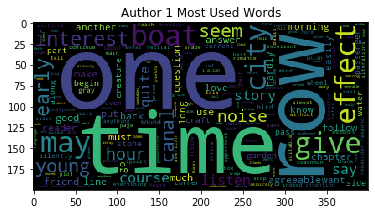

In [5]:
plt.title("Author 1 Most Used Words")
plt.imshow(WordCloud().generate(one_sample_per_author.iloc[0]['text clean']))


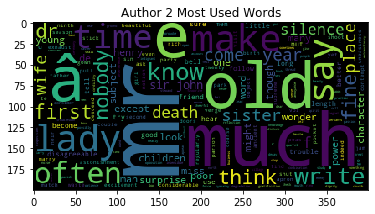

In [6]:
plt.title("Author 2 Most Used Words")
plt.imshow(WordCloud().generate(one_sample_per_author.iloc[1]['text clean']))

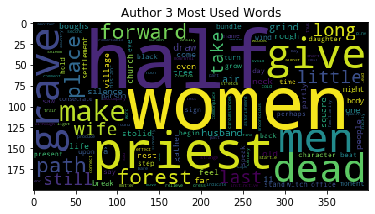

In [7]:
plt.title("Author 3 Most Used Words")
plt.imshow(WordCloud().generate(one_sample_per_author.iloc[2]['text clean']))

The word clouds above shows which words the authors used most commonly in their literature. From the three different word clouds, we can see that each author discusses varying topics that will ultimately help us identify the authors with sophisticated NLP models.

## Baseline Model
- Baseline model constructed using bag of words for both clean (no stopwords and lemmatised) and not clean text data.
- Configured using sci-kit learn's built in Gaussian Naive Bayes multi class classifier

#### Raw Text Baseline Model

In [8]:
X = df['text']
y = df['author'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.65, random_state=10)

In [9]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train)
X_test  = vectorizer.transform(X_test)

In [10]:
model = GaussianNB()
model.fit(X_train.toarray(), y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [11]:
y_predtrain = model.predict(X_train.toarray())

In [12]:
accuracyTrain = accuracy_score(y_train, y_predtrain)
print("Train Accuracy: " + str(accuracyTrain))

Train Accuracy: 0.986905839144089


In [13]:
y_pred = model.predict(X_test.toarray())

In [14]:
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy: " + str(accuracy))

Test Accuracy: 0.41512137800578947


#### Cleaned Text Baseline Model


In [15]:
X = df['text clean']
y = df['author'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.65, random_state=10)

In [16]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train)
X_test  = vectorizer.transform(X_test)

In [17]:
model = GaussianNB()
model.fit(X_train.toarray(), y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [18]:
y_predtrain = model.predict(X_train.toarray())

In [19]:
accuracyTrain = accuracy_score(y_train, y_predtrain)
print("Train Accuracy: " + str(accuracyTrain))

Train Accuracy: 0.9597594081013466


In [20]:
y_pred = model.predict(X_test.toarray())

In [21]:
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy: " + str(accuracy))

Test Accuracy: 0.43925367573299706


From the two Gaussian Naive Bayes Models above, there is a slight boost in accuracy for the test dataset when we remove stopwards and lemmatised the text. Additionally, the model appears to be overfitting the train dataset for both clean and not cleaned data since their is high accuracy for predicting the trained data but poor accuracy for the test data.

# Deep Learning : Nueral Nets
- Initial model built as a LSTM RNN using the raw text
- Represented the words in each text by translating texts into real valued vectors using a Keras Tokenizer and use the Keras pad_sequences function to make sure all the entries have the same length

In [22]:
max_words = 100000
max_length = 1000
embedding_dim = 100
tokenizer = Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df.text)

In [23]:
labels = to_categorical(df.author - 1)
data = tokenizer.texts_to_sequences(df.text)
data = pad_sequences(data, max_length)
train_data, test_data, train_label, test_label = train_test_split(data, labels, test_size = 0.10, random_state = 30)

In [24]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=train_data.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(50, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 100)         10000000  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 1000, 100)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 50)                5050      
Total params: 10,085,450
Trainable params: 10,085,450
Non-trainable params: 0
_________________________________________________________________
None


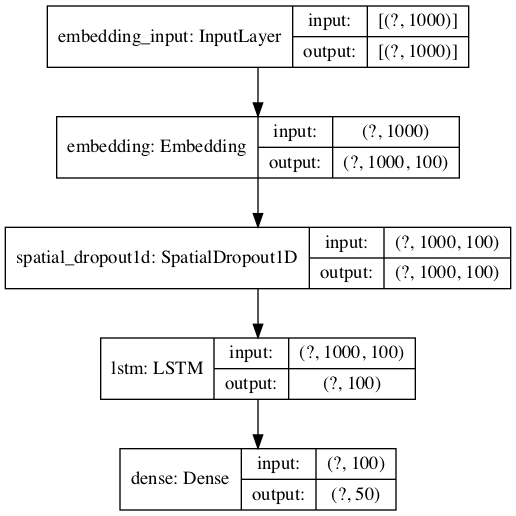

In [25]:
plot_model(model, to_file='model1.png', show_shapes=True, show_layer_names=True)


In [26]:
epochs = 8
batch_size = 64
fitting = model.fit(train_data, train_label, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Epoch 1/8
680/680 [==============================] - 686s 1s/step - loss: 3.4593 - accuracy: 0.1330 - val_loss: 3.2186 - val_accuracy: 0.1969
Epoch 2/8
680/680 [==============================] - 1846s 3s/step - loss: 3.1502 - accuracy: 0.2056 - val_loss: 3.1201 - val_accuracy: 0.1894
Epoch 3/8
680/680 [==============================] - 730s 1s/step - loss: 2.9525 - accuracy: 0.2397 - val_loss: 2.7997 - val_accuracy: 0.2604
Epoch 4/8
680/680 [==============================] - 4474s 7s/step - loss: 2.8508 - accuracy: 0.2579 - val_loss: 2.9273 - val_accuracy: 0.2440
Epoch 5/8
680/680 [==============================] - 10787s 16s/step - loss: 2.6883 - accuracy: 0.2906 - val_loss: 2.5771 - val_accuracy: 0.3001
Epoch 6/8
680/680 [==============================] - 785s 1s/step - loss: 2.5226 - accuracy: 0.3163 - val_loss: 2.5976 - val_accuracy: 0.2964
Epoch 7/8
680/680 [==============================] - 1426s 2s/step - loss: 2.3979 - accuracy: 0.3504 - val_loss: 2.4187 - val_accuracy: 0.3360


In [27]:
score = model.evaluate(test_data, test_label, verbose=1)
print("Loss :", score[0])
print("Accuracy :", score[1])

168/168 [==============================] - 17s 102ms/step - loss: 2.2250 - accuracy: 0.3826
Loss : 2.2250428199768066
Accuracy : 0.3826378583908081


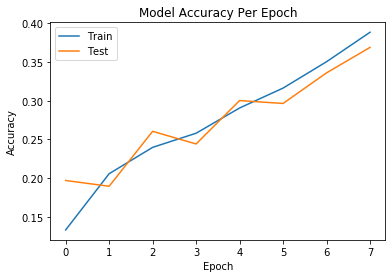

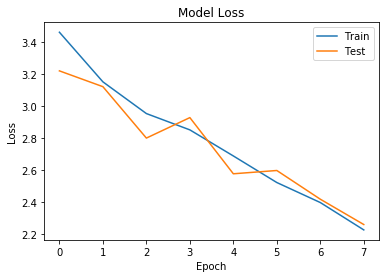

In [28]:
plt.title('Model Accuracy Per Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(fitting.history['accuracy'])
plt.plot(fitting.history['val_accuracy'])
plt.legend(['Train','Test'])
plt.show()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(fitting.history['loss'])
plt.plot(fitting.history['val_loss'])
plt.legend(['Train','Test'])
plt.show()

## Improved Deep Learning Nueral Net
- Added Convolutional Layer and test on not cleaned data
- Combined CNN and LSTM models to achieve maximum results
- Convolutional layer and max pooling layer before the LSTM to reduce dimensions and extract features


In [29]:
max_words = 180000
max_length = 1000
embedding_dim = 100
tokenizer = Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df.text)

In [30]:
labels = to_categorical(df.author - 1)
data = tokenizer.texts_to_sequences(df.text)
data = pad_sequences(data, max_length)
train_data, test_data, train_label, test_label = train_test_split(data, labels, test_size = 0.10, random_state = 30)

In [31]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=train_data.shape[1]))
model.add(Conv1D(filters = 32, kernel_size = 5, padding="same", activation="relu"))
model.add(MaxPooling1D(pool_size = 2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(50, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 100)         18000000  
_________________________________________________________________
conv1d (Conv1D)              (None, 1000, 32)          16032     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 500, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
Total params: 18,074,282
Trainable params: 18,074,282
Non-trainable params: 0
_________________________________________________________________
None


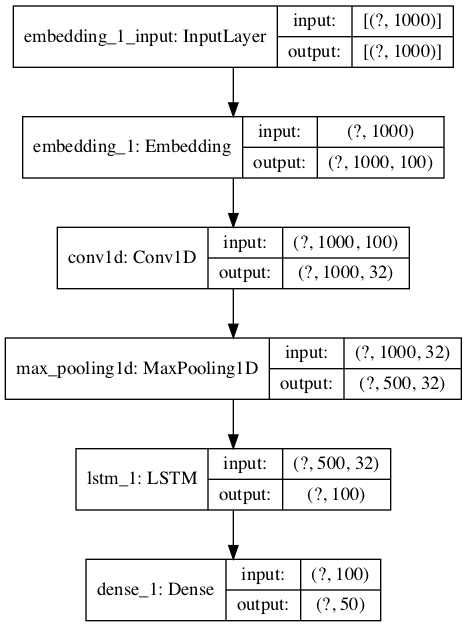

In [32]:
plot_model(model, to_file='model2.png', show_shapes=True, show_layer_names=True)

In [33]:
epochs = 8
batch_size = 64
fitting = model.fit(train_data, train_label, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Epoch 1/8
680/680 [==============================] - 459s 675ms/step - loss: 3.3704 - accuracy: 0.1402 - val_loss: 3.3926 - val_accuracy: 0.1507
Epoch 2/8
680/680 [==============================] - 442s 650ms/step - loss: 3.0455 - accuracy: 0.1833 - val_loss: 2.9885 - val_accuracy: 0.1801
Epoch 3/8
680/680 [==============================] - 440s 647ms/step - loss: 2.9227 - accuracy: 0.2013 - val_loss: 2.8494 - val_accuracy: 0.2283
Epoch 4/8
680/680 [==============================] - 440s 647ms/step - loss: 2.7836 - accuracy: 0.2381 - val_loss: 2.7811 - val_accuracy: 0.2521
Epoch 5/8
680/680 [==============================] - 440s 647ms/step - loss: 2.6315 - accuracy: 0.2839 - val_loss: 2.4518 - val_accuracy: 0.3233
Epoch 6/8
680/680 [==============================] - 440s 647ms/step - loss: 2.3194 - accuracy: 0.3430 - val_loss: 2.2212 - val_accuracy: 0.3672
Epoch 7/8
680/680 [==============================] - 440s 648ms/step - loss: 2.1182 - accuracy: 0.3873 - val_loss: 2.0966 - val_ac

In [34]:
score = model.evaluate(test_data, test_label, verbose=1)
print("Loss :", score[0])
print("Accuracy :", score[1])

168/168 [==============================] - 9s 53ms/step - loss: 1.9565 - accuracy: 0.4311
Loss : 1.956466794013977
Accuracy : 0.43107303977012634


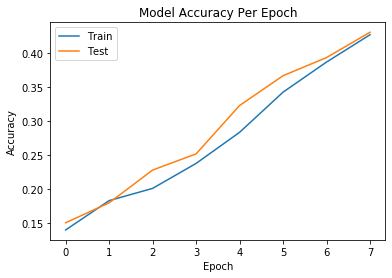

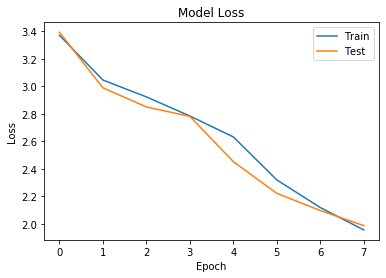

In [35]:
plt.title('Model Accuracy Per Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(fitting.history['accuracy'])
plt.plot(fitting.history['val_accuracy'])
plt.legend(['Train','Test'])
plt.show()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(fitting.history['loss'])
plt.plot(fitting.history['val_loss'])
plt.legend(['Train','Test'])
plt.show()

## Final Model
- Using no stopwords and stemming as our data set
- Convolutional Layer used to further increase performance
- Finetuned the hyperparameter for the number of top words in the Tokenizer


In [36]:
max_words = 180000
max_length = 1000
embedding_dim = 100
tokenizer = Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['text clean'])

In [37]:
labels = to_categorical(df.author - 1)
data = tokenizer.texts_to_sequences(df['text clean'])
data = pad_sequences(data, max_length)
train_data, test_data, train_label, test_label = train_test_split(data, labels, test_size = 0.10, random_state = 30)

In [38]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=train_data.shape[1]))
model.add(Conv1D(filters = 32, kernel_size = 5, padding="same", activation="relu"))
model.add(MaxPooling1D(pool_size = 2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(50, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 100)         18000000  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1000, 32)          16032     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 500, 32)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
Total params: 18,074,282
Trainable params: 18,074,282
Non-trainable params: 0
_________________________________________________________________
None


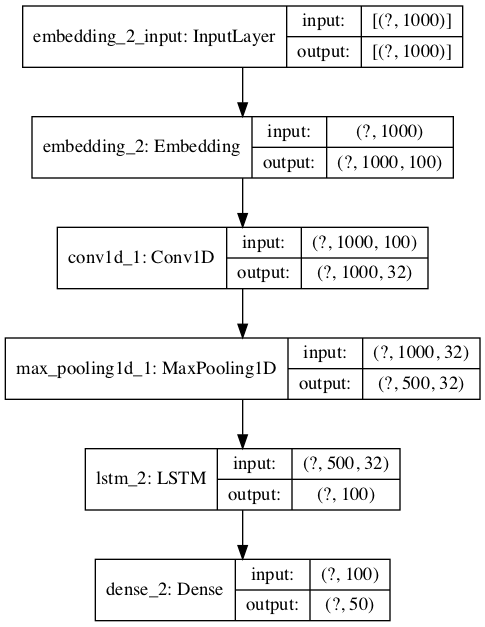

In [39]:
plot_model(model, to_file='model2.png', show_shapes=True, show_layer_names=True)

In [40]:
epochs = 25
batch_size = 64
fitting = model.fit(train_data, train_label, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Epoch 1/25
680/680 [==============================] - 452s 665ms/step - loss: 3.1728 - accuracy: 0.1641 - val_loss: 2.8963 - val_accuracy: 0.1985
Epoch 2/25
680/680 [==============================] - 440s 647ms/step - loss: 2.6495 - accuracy: 0.2798 - val_loss: 2.4081 - val_accuracy: 0.3289
Epoch 3/25
680/680 [==============================] - 436s 642ms/step - loss: 2.2177 - accuracy: 0.3740 - val_loss: 2.1751 - val_accuracy: 0.3825
Epoch 4/25
680/680 [==============================] - 437s 642ms/step - loss: 1.9040 - accuracy: 0.4547 - val_loss: 1.8296 - val_accuracy: 0.4748
Epoch 5/25
680/680 [==============================] - 437s 642ms/step - loss: 1.6280 - accuracy: 0.5252 - val_loss: 1.7046 - val_accuracy: 0.5140
Epoch 6/25
680/680 [==============================] - 437s 642ms/step - loss: 1.4201 - accuracy: 0.5829 - val_loss: 1.4600 - val_accuracy: 0.5715
Epoch 7/25
680/680 [==============================] - 437s 642ms/step - loss: 1.2505 - accuracy: 0.6325 - val_loss: 1.3167 -

In [41]:
score = model.evaluate(test_data, test_label, verbose=1)
print("Loss :", score[0])
print("Accuracy :", score[1])

168/168 [==============================] - 9s 53ms/step - loss: 0.7947 - accuracy: 0.8258
Loss : 0.794687032699585
Accuracy : 0.8258196711540222


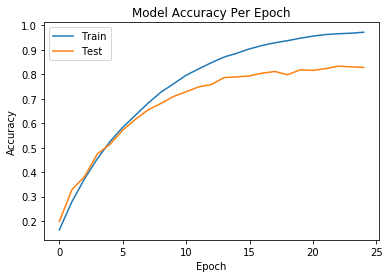

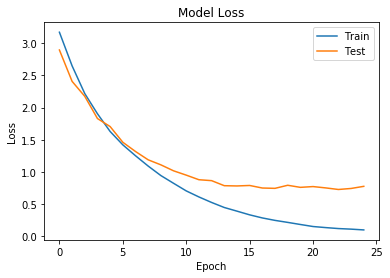

In [42]:
plt.title('Model Accuracy Per Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(fitting.history['accuracy'])
plt.plot(fitting.history['val_accuracy'])
plt.legend(['Train','Test'])
plt.show()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(fitting.history['loss'])
plt.plot(fitting.history['val_loss'])
plt.legend(['Train','Test'])
plt.show()

In [50]:
predictions = model.predict(test_data)

In [44]:
predicted_classes = np.argmax(predictions, axis=1)

In [45]:
actual_classes = np.argmax(test_label, axis=1)

In [46]:
report = metrics.classification_report(actual_classes, predicted_classes)
print(report)    

              precision    recall  f1-score   support

           0       0.72      0.82      0.77        78
           1       0.50      0.37      0.42        41
           2       0.28      0.65      0.39        17
           3       0.71      0.52      0.60       152
           5       0.71      0.46      0.56        37
           7       0.89      0.96      0.92       728
           8       0.90      0.66      0.76        99
           9       0.78      0.74      0.76        77
          10       0.41      0.64      0.50        28
          11       0.50      0.80      0.62        56
          12       0.76      0.65      0.70        43
          13       0.91      0.89      0.90       279
          14       0.85      0.88      0.86       141
          15       0.47      0.33      0.39        21
          16       0.70      0.41      0.52        75
          17       0.88      0.71      0.78        99
          18       0.87      0.86      0.87       157
          19       0.95    

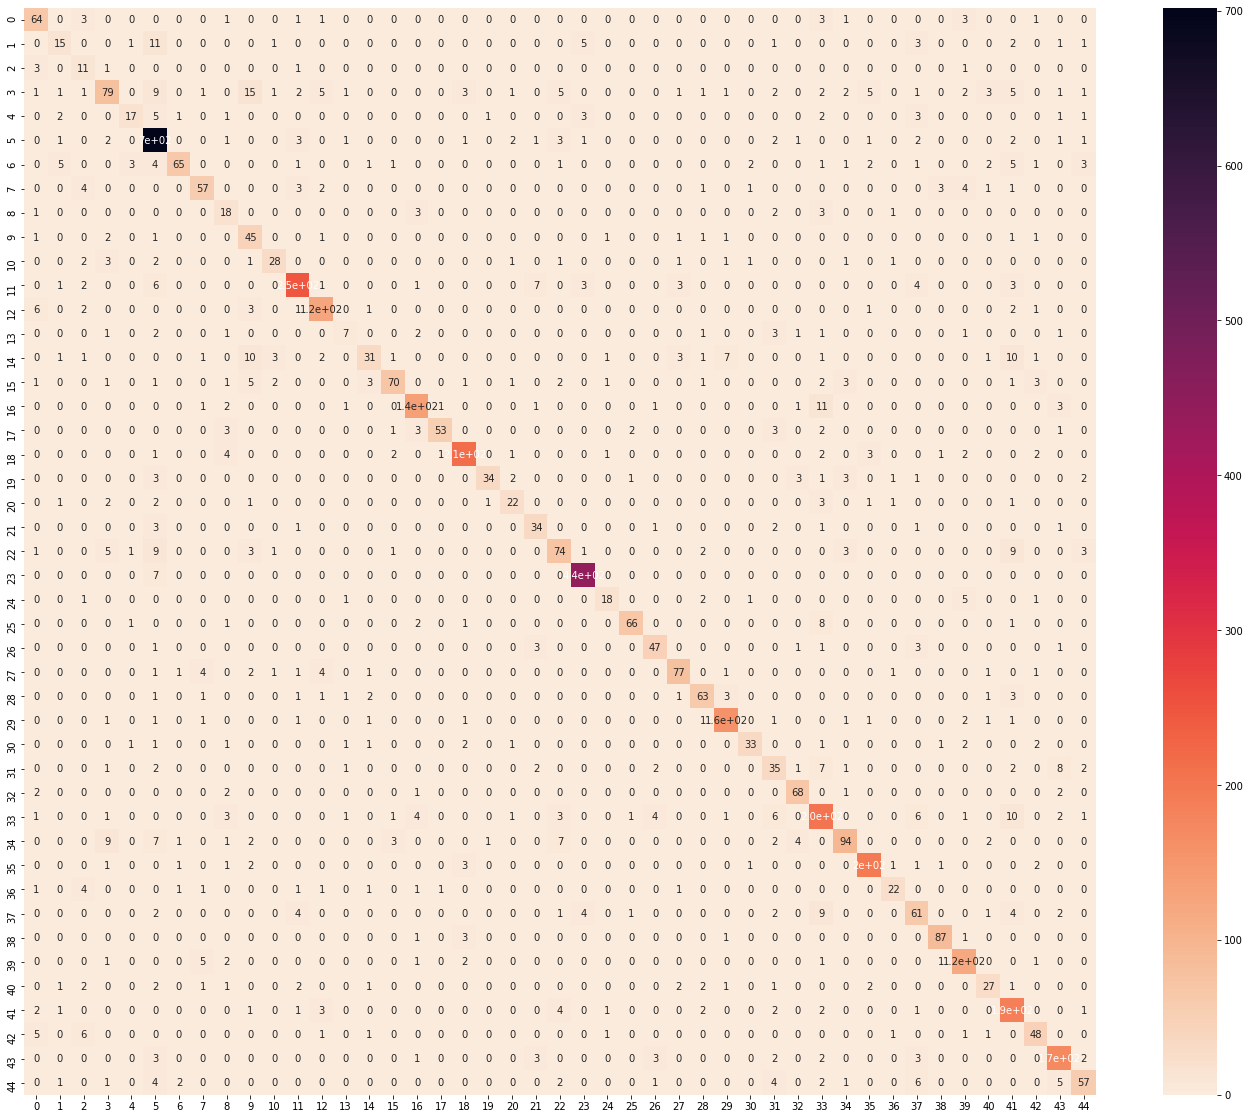

In [49]:
plt.figure(figsize = (24,20))
sn.heatmap(metrics.confusion_matrix(y_true=actual_classes, y_pred=predicted_classes),cmap = sn.cm.rocket_r, annot = True)

## Conclusion
The results, plots, and heatmap from above all portray how well our final deep learning nueral network performed on the train and test dataset. Our final model greatly improved on accuracy for our baseline by growing from .4 to .8 accuracy on the test dataset. This improvement and final result well surpassed our expectations that were set pretty low since the dataset we chose had 50 authors and it is extremly difficult to classify for that many elements. Altogether, this level of accuracy and the ability for our algorithm to be applied to many other datasets is promising for authorship attribution.